# Numerical solution of the Fokker-Planck Equation

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

#### The Fokker Planck equation for the phase space probability distribution of the noisy van der Pol oscillator reads
$$
\frac{\partial w(\xi_i,t)}{\partial t}=-\frac{\partial}{\partial\xi_i}D_iw(\xi_i,t)+\frac{1}{2}
\frac{\partial^2 }{\partial\xi_i\partial\xi_j}D_{ij}w(\xi_i,t)
$$
with the vector $\mathbf{\xi}=(x,v)^T$ and
\begin{align}
D_x^{(1)}&=v\\
D_v^{(1)}&=(2-x^2)v-x\\
D_{vv}^{(1)}&=g\\
\end{align}
where the nonliearity $(2-x^2)v$ was taken form Gradisek, J et. al PRE 62, 3146

In [2]:
# 1st derivative w.r.t. x
def dwdx(m):
    #dwdxback=3*m-4*np.roll(m,shift=1,axis=1)+np.roll(m,shift=2,axis=1)
    #dwdxforw=-3*np.roll(m,shift=-2,axis=1)+4*np.roll(m,shift=-1,axis=1)-3*m
    dwdxback=m-np.roll(m,shift=1,axis=1)
    dwdxforw=np.roll(m,shift=-1,axis=1)-m
    return Dxplus*dwdxback+Dxminus*dwdxforw
# 1st central derivative w.r.t. v
def dwdv(m):
    #dwdvback=3*m-4*np.roll(m,shift=1,axis=0)+np.roll(m,shift=2,axis=0)
    #dwdvforw=-3*np.roll(m,shift=-2,axis=0)+4*np.roll(m,shift=-1,axis=0)-3*m
    dwdvback=m-np.roll(m,shift=1,axis=0)
    dwdvforw=np.roll(m,shift=-1,axis=0)-m
    return Dvplus*dwdvback+Dvminus*dwdvforw
# 2nd derivative w.r.t. v
def d2wdv2(m):
    return np.roll(m,shift=-1,axis=0)-2.0*m+np.roll(m,shift=1,axis=0)

#### In the case of a van der Pol oscillator we have
$$
\frac{\partial w(x,v,t)}{\partial t}=-(2-x^2)w(x,v,t)-v\frac{\partial w(x,v,t)}{\partial x}+
(x-2v+x^2v)\frac{\partial w(x,v,t)}{\partial v}+
g\frac{\partial^2 w(x,v,t)}{\partial v^2}
$$
In terms of finite differences with Euler forward we have
$$
w(x,v,t+\Delta t)=
(1-a1*\Delta t)\cdot w(x,v,t)
-a2*\frac{w(x+\Delta x,v,t)-w(x-\Delta x,v,t)}{2\Delta x}\Delta t
-a3*\frac{w(x,v+\Delta v,t)-w(x,v-\Delta v,t)}{2\Delta v} \Delta t
+g\frac{w(x,v+\Delta v,t)-2\cdot w(x,v,t)+w(x,v-\Delta v,t)}{\Delta v^2}\Delta t
$$

In [3]:
NX=2001
NV=2001
x,v=np.meshgrid(np.linspace(-10,10,NX),np.linspace(-10,10,NV))
#
dx=x[0,-1]-x[0,-2]
dv=v[-1,0]-v[-2,0]
dt=.00001 # timestep
a1=(2-x*x)*dt
a2=v*dt/dx
a3=(-x+2*v-x*x*v)*dt/dx
#
Dxplus=(a2>=0)*a2
Dxminus=(a2<0)*a2
Dvplus=(a3 >=0)*a3
Dvminus=(a3 <0)*a3
#
c=1.0/dv/dv    # diffusion constant
#
# Initial condition
wxv=np.zeros((NX,NV))
wxv[(NX//2-50):(NX//2+50),(NX//2-50):(NX//2+50)]=1.0
F=np.array([wxv[:,1000]])
#

In [28]:
# Integrate forward for Niter steps saving snapshots every Nsnap iterations
Niter=10000
Nsnap=100
# Integration loop
for i in np.arange(Niter):
    # This is the discretized FPE as given above. The algorithm holds in the domain
    wxv[1:-1,1:-1]=(wxv-a1*wxv-dwdx(wxv)-dwdv(wxv)+c*d2wdv2(wxv)*dt/2.)[1:-1,1:-1]
    # The boundary conditions are of Neumann type, i.e. 1st derivative perpendicular 
    # to boundary is zero. Here we apply a second order scheme
    wxv[0,:]=2*dx*(4*wxv[1,:]-wxv[2,:])/3
    wxv[-1,:]=2*dx*(4*wxv[-2,:]-wxv[-3,:])/3
    wxv[:,0]=2*dx*(4*wxv[:,1]-wxv[:,2])/3
    wxv[:,-1]=2*dx*(4*wxv[:,-2]-wxv[:,-3])/3
    # Klick! Snapshot taken
    if i%Nsnap==0:
        F=np.append(F,[wxv[:,1000]],axis=0)

<IPython.core.display.Javascript object>


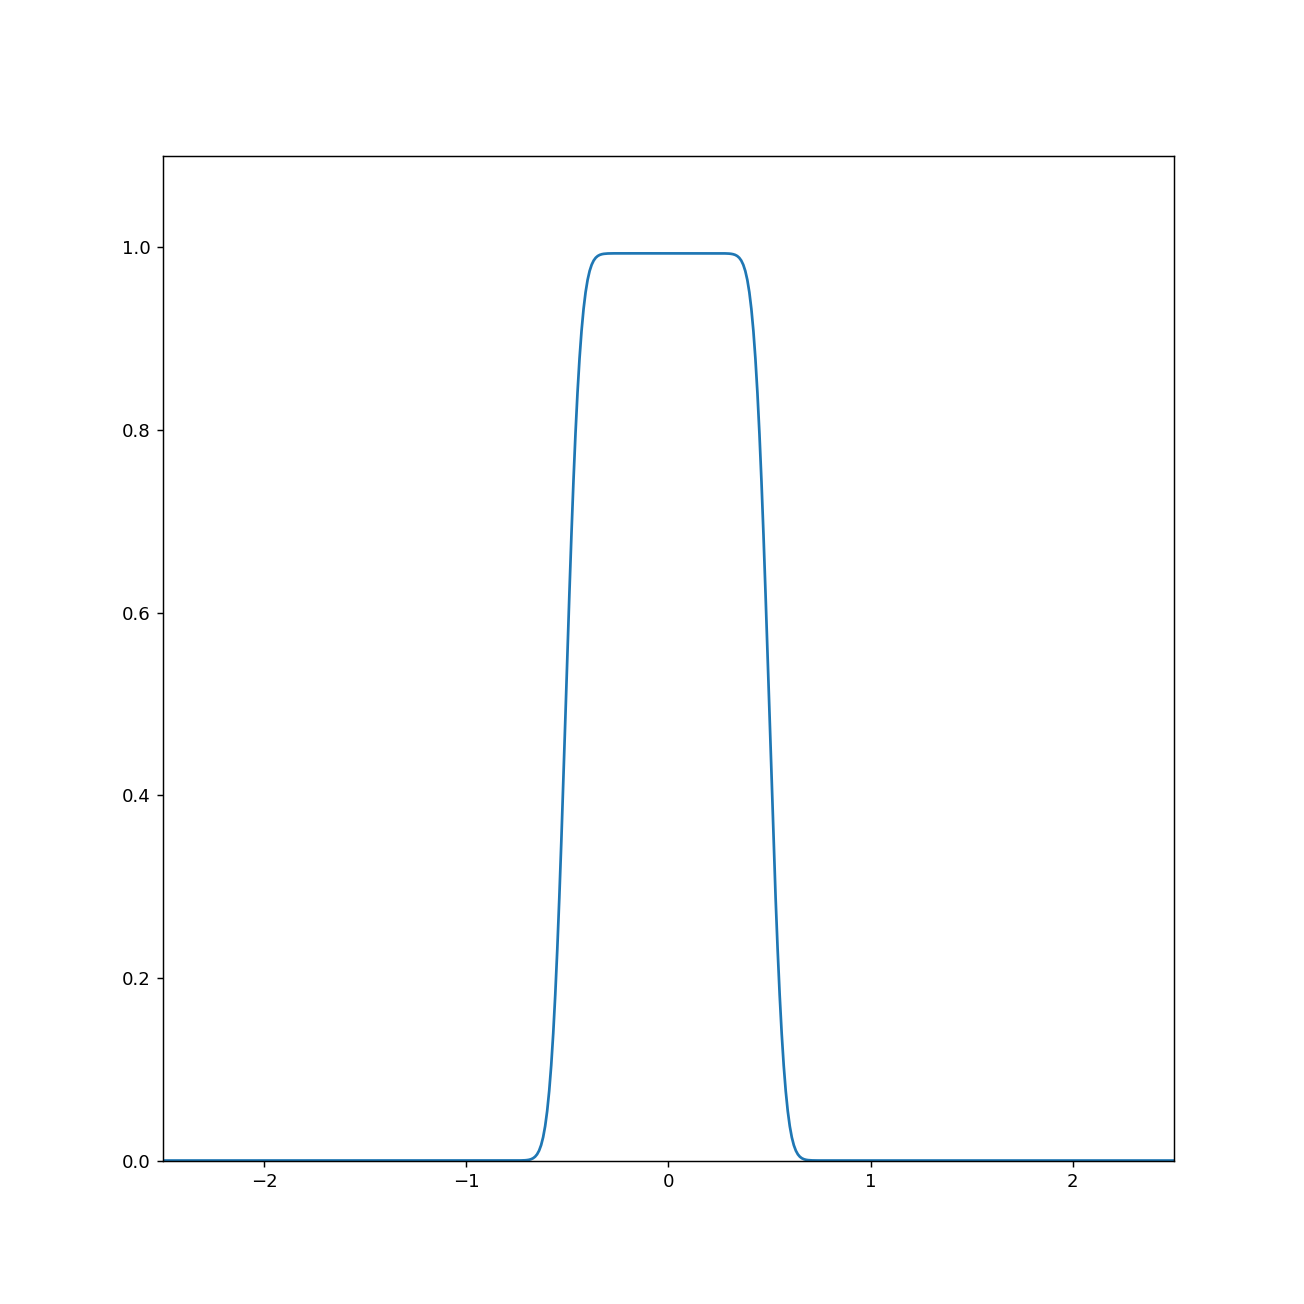

In [44]:
# Let's plotit
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(xlim=(-2.5, 2.5), ylim=(0, 1.1))
#
# We plot along v from -10 to 10, even if the xlim-window above is smaller 
vcoords=np.linspace(-10,10,NV)
line, = ax.plot(vcoords,F[0])  # the first line to plot
# her we update the ydata of our line plot
def animate(i):
    line.set_ydata(F[i,:])
    
anim = animation.FuncAnimation(fig,animate,interval=10,frames=F.shape[0],blit=False)

plt.show()

In [41]:
anim.save('FPEbyAG.mp4')

In [43]:
line?